In [409]:
#import necessary libraries and Modules
import ImageManipFuncs as IMF
import PlottingFuncs as PF
import ImageAnalysis as IA
import myGUI 

import importlib
import cv2
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import os
import ipywidgets as widgets
from IPython.display import display
import math
from PIL import Image, ImageDraw, ImageTk, ImageOps
import tkinter as tk
from tkinter import ttk
from astropy.io import fits
from skimage.morphology import skeletonize
from skimage import io
import csv
import Metric

In [410]:
importlib.reload(IMF)
importlib.reload(PF)
importlib.reload(IA)

<module 'ImageAnalysis' from 'c:\\Users\\HP\\Documents\\JHU_Academics\\Research\\PHANGS\\PHANGSDustFill\\ImageAnalysis.py'>

In [411]:
# Specify the path to your FITS file
fits_file = r"C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\galaxysim_SigmaHI_scaledecomposed_intensitytransformed\galaxysim_SigmaHI_CDDss0016pc_arcsinh0p1.fits"

# Load the FITS file data
hdul = fits.open(fits_file)
image_data = np.array(hdul[0].data)  # Assuming the image data is in the primary HDU
header = hdul[0].header
# Set the desired figure size (width, height) in inches
fig_size = (6, 6)  # Adjust this to your desired size

# Create a figure with the specified size
plt.figure(figsize=fig_size)


<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

(2000, 2000)


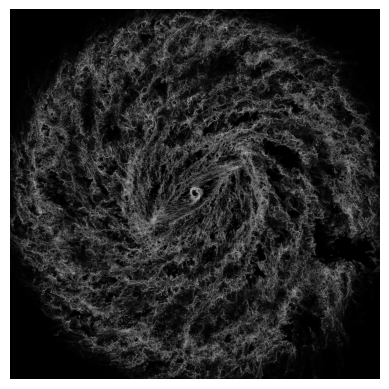

In [412]:

cv2.imwrite(r'C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\Original.png', np.flipud(image_data))

# Display the image using Matplotlib without axes and colorbar
plt.imshow(np.flipud(image_data), cmap='gray')  # Adjust cmap if your data is not grayscale
print(np.shape(image_data))
plt.axis('off')  # Turn off axes

# Close the FITS file
hdul.close()





In [413]:
# import numpy as np
# from scipy.ndimage import minimum_filter, maximum_filter

# def local_min_max_normalization(image, window_size):
#     """
#     Perform local min/max normalization on an image using a sliding window.

#     Parameters:
#     - image: 2D numpy array representing the grayscale image to be normalized.
#     - window_size: Size of the sliding window (must be an odd integer).

#     Returns:
#     - normalized_image: 2D numpy array with local min/max normalized values.
#     """
#     # Check that window_size is odd
#     if window_size % 2 == 0:
#         raise ValueError("window_size must be an odd integer.")

#     # Ensure the image is in float format for precision
#     image = image.astype(np.float64)

#     # Compute the local min and max using minimum_filter and maximum_filter
#     local_min = minimum_filter(image, size=window_size, mode='reflect')
#     local_max = maximum_filter(image, size=window_size, mode='reflect')

#     # Perform local min/max normalization
#     # Avoid division by zero by adding a small epsilon to the denominator
#     epsilon = 1e-10
#     normalized_image = (image - local_min) / (local_max - local_min + epsilon)

#     # Clip values to the range [0, 1]
#     normalized_image = np.clip(normalized_image, 0, 1)

#     return normalized_image

# # Example usage
# if __name__ == "__main__":
#     import matplotlib.pyplot as plt

#     # Create a test image (for demonstration)
#     test_image = image_data

#     # Apply local min/max normalization
#     window_size = 31  # Example window size
#     normalized_image = local_min_max_normalization(test_image, window_size)

#     # Display the results
#     plt.subplot(1, 2, 1)
#     plt.title('Original Image')
#     plt.imshow(test_image, cmap='gray')

#     plt.subplot(1, 2, 2)
#     plt.title('Normalized Image')
#     plt.imshow(normalized_image, cmap='gray')

#     plt.show()


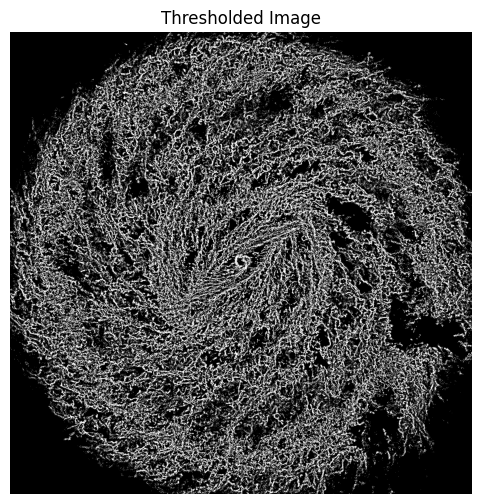

In [414]:

# Convert the FITS image data to 8-bit format if necessary
# Normalize data to the range [0, 255]

image_data = 255 * (image_data - np.min(image_data)) / (np.max(image_data) - np.min(image_data))
image_data = image_data.astype(np.uint8)

total_thresh = cv2.adaptiveThreshold(image_data, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 21, -10)

cv2.imwrite(r'C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\ThresholdedImage.png', np.flipud(total_thresh))

# Display the results
plt.figure(figsize=(8, 6))

plt.title('Thresholded Image')
plt.imshow(np.flipud(total_thresh), cmap='gray')
plt.axis('off')
image_data = total_thresh

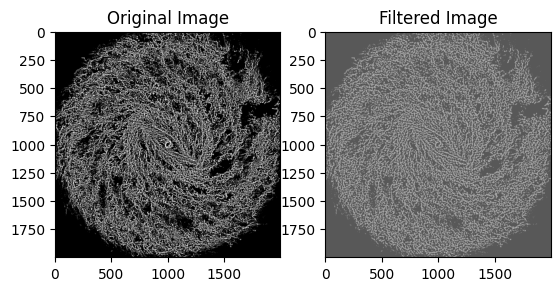

In [415]:
import numpy as np
import cv2
from scipy.ndimage import gaussian_filter
from scipy.linalg import eigh
import matplotlib.pyplot as plt

def shock_filter(input_image, sigma=2, rho=0.5, num_iterations=15):
    """
    Coherence-enhancing shock filter.

    Parameters:
    - input_image: Input image (2D numpy array) to be considered by coherence-enhancing shock filter.
    - sigma: Standard deviation of Gaussian filter for image smoothing.
    - rho: Standard deviation of Gaussian filter for structure tensor.
    - num_iterations: Number of iterations for filtering.

    Returns:
    - Filtered image (2D numpy array).
    """
    if input_image.ndim == 3:
        input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2GRAY)
    
    input_image = input_image.astype(np.float64)
    v = gaussian_filter(input_image, sigma)

    ut = np.zeros_like(input_image)
    for _ in range(num_iterations):
        # Compute gradients
        ux, uy = np.gradient(input_image)
        
        # Compute second-order gradients
        vx, vy = np.gradient(v)
        vxx, vxy = np.gradient(vx)
        _, vyy = np.gradient(vy)
        
        # Compute structure tensor components
        Jxx = gaussian_filter(ux**2, rho)
        Jxy = gaussian_filter(ux*uy, rho)
        Jyy = gaussian_filter(uy**2, rho)

        # Initialize ut array
        ut = np.zeros_like(input_image)
        
        # Process each pixel
        for i in range(input_image.shape[0]):
            for j in range(input_image.shape[1]):
                S = np.array([[Jxx[i, j], Jxy[i, j]],
                              [Jxy[i, j], Jyy[i, j]]])
                eigenvalues, eigenvectors = eigh(S)
                w = eigenvectors[:, 1] / np.linalg.norm(eigenvectors[:, 1])
                
                vxx_ = vxx[i, j]
                vxy_ = vxy[i, j]
                vyy_ = vyy[i, j]
                
                ut[i, j] = -np.sign(vxx_ * w[0]**2 + vxy_ * w[0] * w[1] + vyy_ * w[1]**2)

        # Apply magnitude of gradient to ut
        gradient_magnitude = np.sqrt(ux**2 + uy**2)
        ut *= gradient_magnitude
        
        # Update input_image
        input_image += ut

    return input_image


image_path = r"C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\SegTest.webp"
image_color = cv2.imread(image_path, cv2.IMREAD_COLOR)  # Read in color mode
image = total_thresh

# Apply shock filter
filtered_image = shock_filter(image, sigma=5, rho=.5, num_iterations=1)

# Display the results
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(image, cmap='gray')

plt.subplot(1, 2, 2)
plt.title('Filtered Image')
plt.imshow(filtered_image, cmap='gray')

plt.show()



In [416]:
# Save as FITS
skel_image_file_fits = r'C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\ShockCoherenceInter1.fits'
img = filtered_image
img = img.astype(np.float32)  
hdu = fits.PrimaryHDU(img)
hdul = fits.HDUList([hdu])
hdul.writeto(skel_image_file_fits, overwrite=True)

In [417]:
# import numpy as np
# import cv2
# from scipy.ndimage import gaussian_filter
# from scipy.signal import convolve2d
# import matplotlib.pyplot as plt

# def laplace_filter(beta=10):
#     """ Create a Laplace filter kernel. """
#     L = np.array([[0, -1, 0],
#                   [-1, -4, -1],
#                   [0, -1, 0]])
#     return beta * L

# def directional_gaussian_filter(image, sigma_dg):
#     """ Apply a directional Gaussian filter to the image. """
#     size = int(2 * np.ceil(3 * sigma_dg) + 1)
#     kernel = cv2.getGaussianKernel(size, sigma_dg)
#     kernel = kernel @ kernel.T  # 2D Gaussian kernel
#     return convolve2d(image, kernel, mode='same', boundary='wrap')



# def filament_enhancement(input_image, sigma_gaussian, beta=10, sigma_dg=10.0):
#     input_image = input_image.astype(np.float64)
#     smoothed_image = gaussian_filter(input_image, sigma_gaussian)
#     L = laplace_filter(beta)
#     laplace_image = convolve2d(smoothed_image, L, mode='same', boundary='wrap')

#     # Optional: Take the absolute value if inversion is problematic
#     laplace_image = np.abs(laplace_image)
    
#     enhanced_image = directional_gaussian_filter(laplace_image, sigma_dg)
    
#     # Normalize the enhanced image
#     enhanced_image = (enhanced_image - np.min(enhanced_image)) / (np.max(enhanced_image) - np.min(enhanced_image))

#     return enhanced_image

# # Load an example image
# image = image_data

# # Enhance filaments
# sigma_gaussian = 2
# beta = 50
# sigma_dg = 2
# enhanced_image = filament_enhancement(image, sigma_gaussian, beta, sigma_dg)

# # Display the results
# plt.subplot(1, 2, 1)
# plt.title('Original Image')
# plt.imshow(image, cmap='gray')

# plt.subplot(1, 2, 2)
# plt.title('Enhanced Image')
# plt.imshow(enhanced_image, cmap='gray')

# plt.show()
# print(np.min(enhanced_image), np.max(enhanced_image))


C:\Users\HP\AppData\Local\Temp\ipykernel_2324\895867694.py:14: RuntimeWarning: invalid value encountered in sqrt
  lambda1 = 0.5 * (trace + np.sqrt(trace**2 - 4 * determinant))
C:\Users\HP\AppData\Local\Temp\ipykernel_2324\895867694.py:15: RuntimeWarning: invalid value encountered in sqrt
  lambda2 = 0.5 * (trace - np.sqrt(trace**2 - 4 * determinant))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-285.09866713122324..540.0986671312232].


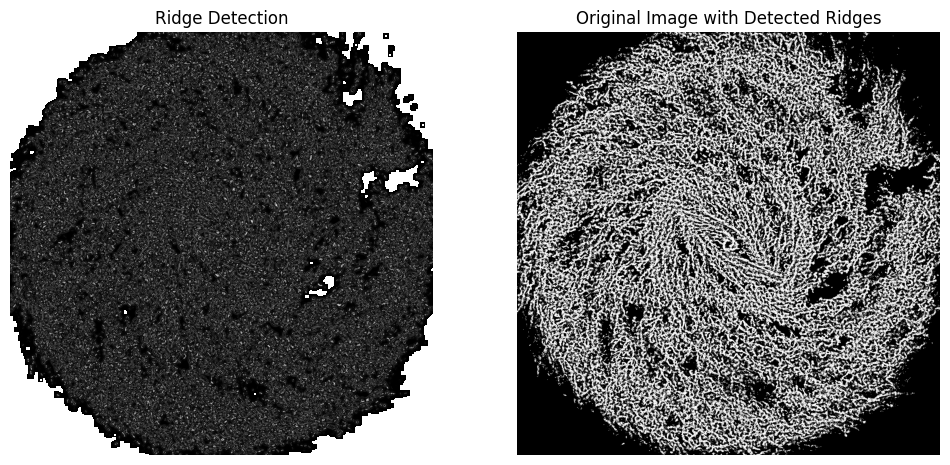

nan


In [500]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

def hessian_matrix(image, sigma):
    Ixx = gaussian_filter(image, sigma=sigma, order=(2, 0))
    Ixy = gaussian_filter(image, sigma=sigma, order=(1, 1))
    Iyy = gaussian_filter(image, sigma=sigma, order=(0, 2))
    return Ixx, Ixy, Iyy

def hessian_eigenvalues(Ixx, Ixy, Iyy):
    trace = Ixx + Iyy
    determinant = Ixx * Iyy - Ixy**2
    lambda1 = 0.5 * (trace + np.sqrt(trace**2 - 4 * determinant))
    lambda2 = 0.5 * (trace - np.sqrt(trace**2 - 4 * determinant))
    return lambda1, lambda2

def ridge_filter(lambda1, lambda2, alpha=0.5, beta=0.5):
    # lambda1, lambda2 = np.abs(lambda1), np.abs(lambda2)
    phi = lambda1 / (lambda2 + np.finfo(float).eps)  # Avoid division by zero
    sigma_ratio = 1 - np.exp(-((phi - 1) ** 2) / (2 * alpha**2))
    sigma_sum = 1 - np.exp(-((lambda1 + lambda2) ** 2) / (2 * beta**2))
    response = sigma_ratio * sigma_sum*(lambda1 < 5)
    return response

def ridge_detection(image, sigma, alpha=0.5, beta=0.5):
    if len(image.shape) == 3:
        image = image[:, :, 0]  # Assuming the image is grayscale with shape (H, W, 1)
    Ixx, Ixy, Iyy = hessian_matrix(image, sigma)
    lambda1, lambda2 = hessian_eigenvalues(Ixx, Ixy, Iyy)
    response = ridge_filter(lambda1, lambda2, alpha, beta)
    return response


image_data = 255-filtered_image
sigma = 4 # Adjust this based on the known scale of your filaments
# image_data[image_data > 50] = 255
ridge_response = ridge_detection(image_data, sigma, alpha = 1,beta = 5)

# Threshold ridge response for overlaying
threshold = np.max(ridge_response) * 0.5  # Adjust threshold as needed
ridge_overlay = np.zeros_like(image_data)
ridge_overlay[ridge_response > threshold] = 1

# Create an RGB image to overlay the ridges
original_image_rgb = np.stack([image_data, image_data, image_data], axis=-1)  # Convert grayscale to RGB
original_image_rgb[ridge_overlay > 0, 0] = 1  # Set red channel for detected ridges
original_image_rgb[ridge_overlay > 0, 1] = 0  # Remove green and blue channels for ridges
original_image_rgb[ridge_overlay > 0, 2] = 0

# Display the images
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(ridge_response, cmap='gray')
plt.title('Ridge Detection')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(255-original_image_rgb)
plt.title('Original Image with Detected Ridges')
plt.axis('off')

plt.show()

print(np.max(ridge_response))


In [501]:
# Save as FITS
skel_image_file_fits = r'C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\ShockCoherenceInter2.fits'
img = ridge_response
img = img.astype(np.float32)  
hdu = fits.PrimaryHDU(img)
hdul = fits.HDUList([hdu])
hdul.writeto(skel_image_file_fits, overwrite=True)

nan nan


DETECTING
deblending


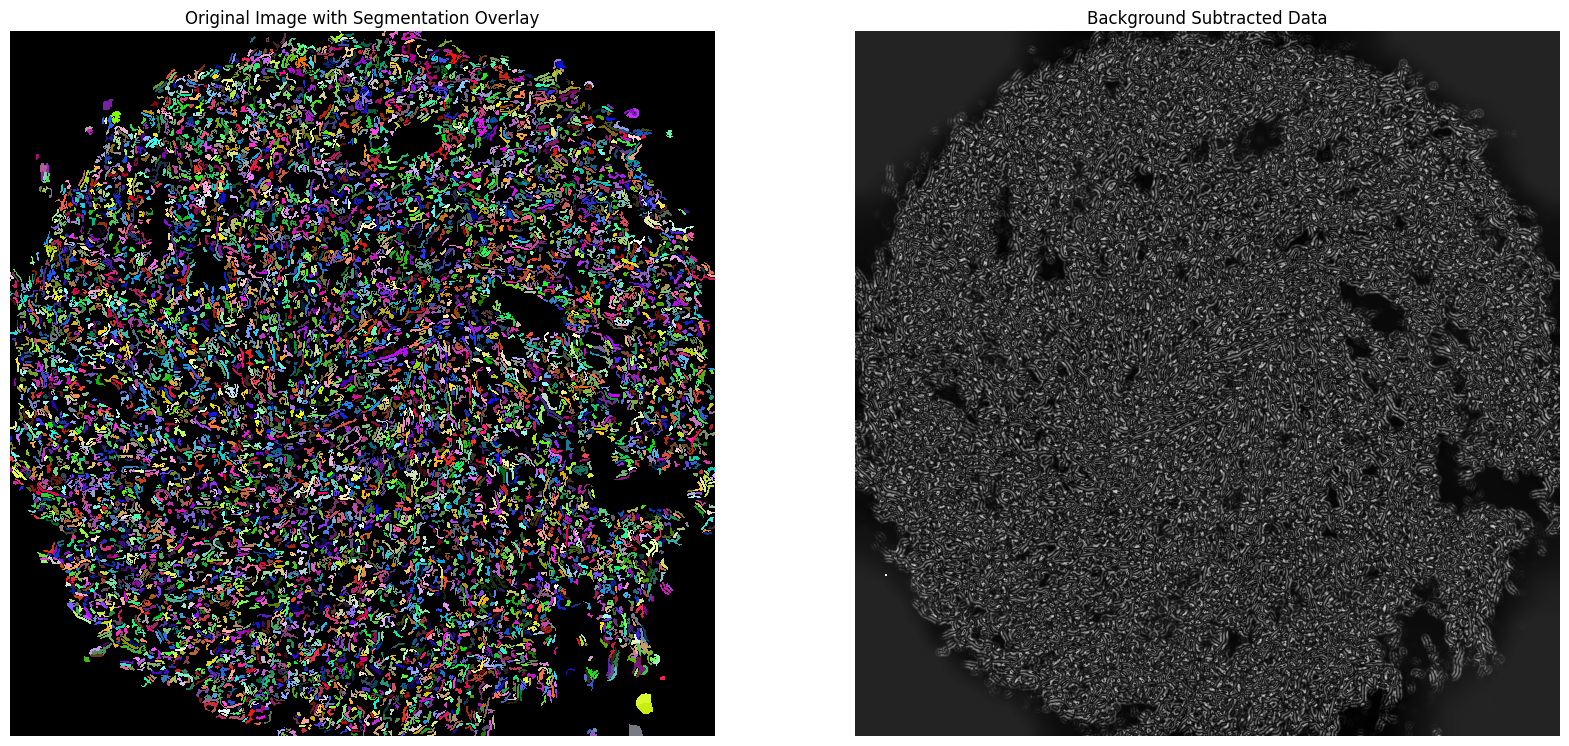

In [493]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils.segmentation import make_2dgaussian_kernel, detect_sources, deblend_sources
from photutils.background import Background2D, MedianBackground
from astropy.convolution import convolve
from matplotlib.colors import ListedColormap

source_pixel_min = 50
deblend_pixel_min = 25
threshold = .3

path = r'C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\SmallFilamentsGone.png'
data = ridge_response
data = data.astype(np.float64)
print(np.max(data), np.min(data))
# Background subtraction
bkg_estimator = MedianBackground()
bkg = Background2D(data, (50, 50), filter_size=(3, 3), bkg_estimator=bkg_estimator)
data -= bkg.background

# Thresholding and convolution
threshold = threshold_factor*bkg.background_rms
kernel = make_2dgaussian_kernel(3.0, size=11)
convolved_data = convolve(data, kernel)

# Source detection and deblending
print('DETECTING')
segment_map = detect_sources(convolved_data, threshold, npixels=int(source_pixel_min))
print("deblending")
segment_map = deblend_sources(convolved_data, segment_map, npixels=int(deblend_pixel_min), nlevels=100, contrast=0.001, progress_bar=False)

# Colormap and normalization
num_segments = segment_map.data.max()
colors = np.random.rand(num_segments + 1, 3)
colors[0] = [0, 0, 0]  # Background as black
cmap = ListedColormap(colors)

norm = ImageNormalize(stretch=SqrtStretch())
segmentation_image_normalized = norm(segment_map.data)

#segmentation_image_flipped = np.flipud(segmentation_image_normalized)
#data_flipped = np.flipud(data)

# Plot and save
fig, axes = plt.subplots(1, 2, figsize=(20, 12.5))

axes[0].imshow(segmentation_image_normalized, origin='lower', cmap=cmap, alpha=1, interpolation='nearest')
axes[0].set_title('Original Image with Segmentation Overlay')
axes[0].axis('off')

axes[1].imshow(data, cmap='gray', origin='lower')
axes[1].set_title('Background Subtracted Data')
axes[1].axis('off')

# Save the subplot image
subplot_image_path = r'C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\overlaid_subplot_image.png'
plt.imsave(subplot_image_path, np.flipud(segmentation_image_normalized), cmap=cmap)

# Save the binary segmented image
binary_segment_image = (segment_map.data > 0).astype(np.uint8) * 255
image_path_segments = r'C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\segments.png'
plt.imsave(image_path_segments, np.flipud(binary_segment_image), cmap='gray')

# Normalize and save the zoomed image
#data_flipped = data_flipped.astype(np.uint8) * 255
data= np.nan_to_num(data, nan=0)
image_path_zoomed = r'C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\zoomed_image.png'
plt.imsave(image_path_zoomed, np.flipud(data), cmap='gray')

# Show the plot
plt.show()


In [494]:
# Save as FITS
skel_image_file_fits = r'C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\photutils1.fits'
img = skeletonize(binary_segment_image)
threshold = 0
# Create a mask for pixels where the condition is not met
mask = (img > 0) & (image_data<= threshold)

# Set those pixels in the summed data to black (0)
img[mask] = 0
img = img.astype(np.float32)  
hdu = fits.PrimaryHDU(img)
hdul = fits.HDUList([hdu])
hdul.writeto(skel_image_file_fits, overwrite=True)

(-0.5, 1999.5, 1999.5, -0.5)

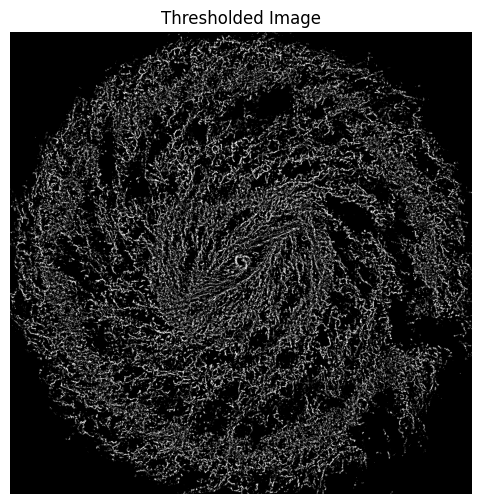

In [422]:
# Load the FITS file
fits_file = r"C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\galaxysim_SigmaHI_scaledecomposed_intensitytransformed\galaxysim_SigmaHI_CDDss0016pc_arcsinh0p1.fits"
hdul = fits.open(fits_file)
image_data = np.array(hdul[0].data)
hdul.close()

# Convert the FITS image data to 8-bit format if necessary
# Normalize data to the range [0, 255]
image_data = 255 * (image_data - np.min(image_data)) / (np.max(image_data) - np.min(image_data))
image_data = image_data.astype(np.uint8)

total_thresh = cv2.adaptiveThreshold(image_data, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 21, -30)

cv2.imwrite(r'C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\ThresholdedImage.png', np.flipud(total_thresh))

# Display the results
plt.figure(figsize=(8, 6))

plt.title('Thresholded Image')
plt.imshow(np.flipud(total_thresh), cmap='gray')
plt.axis('off')


C:\Users\HP\AppData\Local\Temp\ipykernel_2324\519066624.py:8: UserWarning: C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\skeletonized_image.png is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  io.imsave(r'C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\skeletonized_image.png', np.flipud(skeleton))


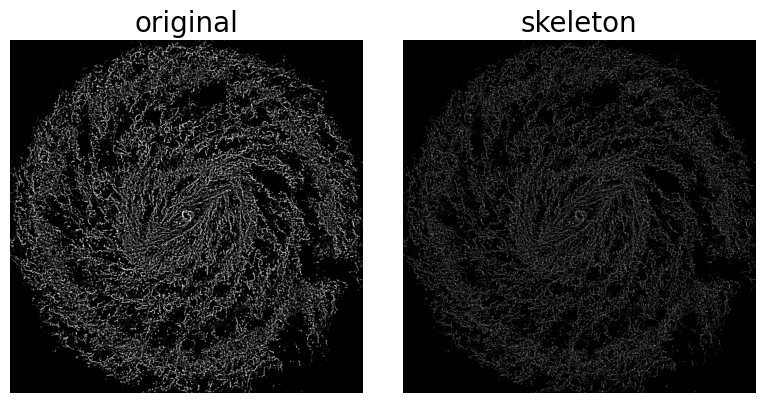

In [423]:
# Assuming th2 is the image to be skeletonized
image = total_thresh

# Perform skeletonization
skeleton = skeletonize(image)

# Save the skeletonized image
io.imsave(r'C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\skeletonized_image.png', np.flipud(skeleton))

# Display results
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4), sharex=True, sharey=True)

ax = axes.ravel()

ax[0].imshow(np.flipud(image), cmap=plt.cm.gray)
ax[0].axis('off')
ax[0].set_title('original', fontsize=20)

ax[1].imshow(np.flipud(skeleton), cmap=plt.cm.gray)
ax[1].axis('off')
ax[1].set_title('skeleton', fontsize=20)

fig.tight_layout()
plt.show()


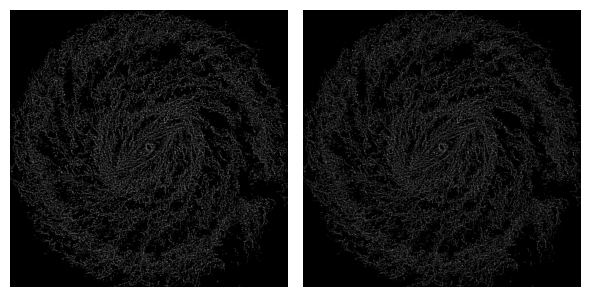

(2000, 2000)


In [424]:
importlib.reload(IA)
importlib.reload(IMF)
def neighbours(x, y, image):
    """Return 8-neighbours of image point P1(x,y), in a clockwise order"""
    img = image
    x_1, y_1, x1, y1 = x - 1, y - 1, x + 1, y + 1
    return [img[x_1][y], img[x_1][y1], img[x][y1], img[x1][y1], img[x1][y], img[x1][y_1], img[x][y_1], img[x_1][y_1]]

def getSkeletonIntersection(skeleton):
    """ Given a skeletonised image, it will give the coordinates of the intersections of the skeleton.
    
    Keyword arguments:
    skeleton -- the skeletonised image to detect the intersections of
    
    Returns: 
    List of 2-tuples (x,y) containing the intersection coordinates
    """
    validIntersection = [[0,1,0,1,0,0,1,0],[0,0,1,0,1,0,0,1],[1,0,0,1,0,1,0,0],
                         [0,1,0,0,1,0,1,0],[0,0,1,0,0,1,0,1],[1,0,0,1,0,0,1,0],
                         [0,1,0,0,1,0,0,1],[1,0,1,0,0,1,0,0],[0,1,0,0,0,1,0,1],
                         [0,1,0,1,0,0,0,1],[0,1,0,1,0,1,0,0],[0,0,0,1,0,1,0,1],
                         [1,0,1,0,0,0,1,0],[1,0,1,0,1,0,0,0],[0,0,1,0,1,0,1,0],
                         [1,0,0,0,1,0,1,0],[1,0,0,1,1,1,0,0],[0,0,1,0,0,1,1,1],
                         [1,1,0,0,1,0,0,1],[0,1,1,1,0,0,1,0],[1,0,1,1,0,0,1,0],
                         [1,0,1,0,0,1,1,0],[1,0,1,1,0,1,1,0],[0,1,1,0,1,0,1,1],
                         [1,1,0,1,1,0,1,0],[1,1,0,0,1,0,1,0],[0,1,1,0,1,0,1,0],
                         [0,0,1,0,1,0,1,1],[1,0,0,1,1,0,1,0],[1,0,1,0,1,1,0,1],
                         [1,0,1,0,1,1,0,0],[1,0,1,0,1,0,0,1],[0,1,0,0,1,0,1,1],
                         [0,1,1,0,1,0,0,1],[1,1,0,1,0,0,1,0],[0,1,0,1,1,0,1,0],
                         [0,0,1,0,1,1,0,1],[1,0,1,0,0,1,0,1],[1,0,0,1,0,1,1,0],
                         [1,0,1,1,0,1,0,0]]
    image = skeleton.copy() / 255
    intersections = []
    for x in range(1, len(image) - 1):
        for y in range(1, len(image[x]) - 1):
            # If we have a white pixel
            if image[x][y] == 1:
                neighbors = neighbours(x, y, image)
                if neighbors in validIntersection:
                    intersections.append((y, x))
    
    # Filter intersections to make sure we don't count them twice or ones that are very close together
    filtered_intersections = []
    for point1 in intersections:
        add_point = True
        for point2 in filtered_intersections:
            if ((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2) < 10**2:
                add_point = False
                break
        if add_point:
            filtered_intersections.append(point1)
    
    return filtered_intersections

# Apply skeletonization
skeleton_image = skeletonize(skeleton)

# Find the intersections
intersections = getSkeletonIntersection(np.array(255*skeleton_image))

# Draw intersections on the original image
#draw_intersections(skeleton_image_path, intersections, output_image_path)

intersects_removed = r'C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\ThresholdedImageNoIntersects.png'

no_intersects = IA.remove_junctions(intersections, skeleton_image, intersects_removed, dot_size = 1)

print(np.shape(no_intersects))

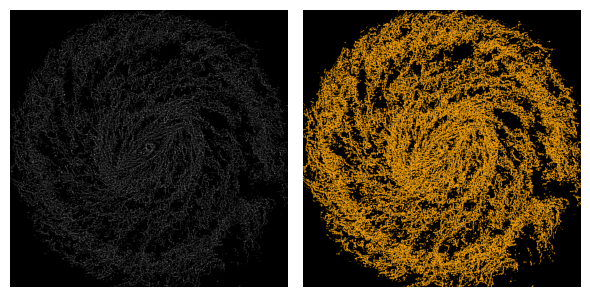

In [425]:
importlib.reload(IA)
labels, stats, num_labels = IA.identify_connected_components(np.array(no_intersects))

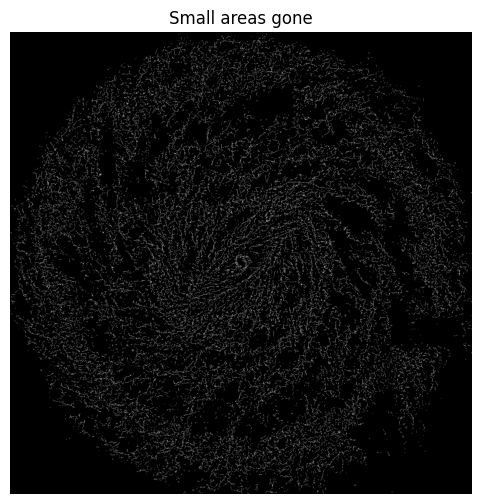

In [426]:
importlib.reload(IA)
small_areas = IA.sort_label_id(num_labels, stats, 5)
img = np.array(no_intersects)

for label_id in small_areas:
    # Extract the bounding box coordinates
    left = stats[label_id, cv2.CC_STAT_LEFT]
    top = stats[label_id, cv2.CC_STAT_TOP]
    width = stats[label_id, cv2.CC_STAT_WIDTH]
    height = stats[label_id, cv2.CC_STAT_HEIGHT]
    for x in range(width):
        for y in range(height):
            img[top:top+height, left:left+width] = 0


# Set the desired figure size (width, height) in inches
fig_size = (6, 6)  # Adjust this to your desired size

# Create a figure with the specified size
plt.figure(figsize=fig_size)

# Display the thresholded image (optional)
plt.imshow(np.flipud(img), cmap='gray')
plt.axis('off')  # Turn off axes
plt.title('Small areas gone')
plt.show()


cv2.imwrite(r'C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\SmallFilamentsGone.png', img)

# Save as FITS
skel_image_file_fits = r'C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\SPRSkel1.fits'   
hdu = fits.PrimaryHDU(img)
hdul = fits.HDUList([hdu])
hdul.writeto(skel_image_file_fits, overwrite=True)

In [427]:
# read the image
importlib.reload(IA)
importlib.reload(PF)
# img = cv2.imread(intersects_removed)

# # convert to gray
# gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# # blur
# blur = cv2.GaussianBlur(gray, (0,0), 1.3, 1.3)
# # apply sobel derivatives
# sobelx = cv2.Sobel(blur,cv2.CV_64F,1,0,ksize=3)
# sobely = cv2.Sobel(blur,cv2.CV_64F,0,1,ksize=3)
# PF.plot_sobel_derivatives(sobelx, sobely)

#filtered_input = r'C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\thresholdwithintersects.png'

sobel_x, sobel_y = IA.apply_sobel_filter_to_components(img, labels, stats, num_labels)

PF.plot_sobel_derivatives(img,sobel_x, sobel_y)



KeyboardInterrupt: 

c:\Users\HP\Documents\JHU_Academics\Research\PHANGS\PHANGSDustFill\PlottingFuncs.py:99: RuntimeWarning: divide by zero encountered in divide
  angle_map = -1 * np.degrees(np.arctan(Gy / Gx))
c:\Users\HP\Documents\JHU_Academics\Research\PHANGS\PHANGSDustFill\PlottingFuncs.py:99: RuntimeWarning: invalid value encountered in divide
  angle_map = -1 * np.degrees(np.arctan(Gy / Gx))
c:\Users\HP\Documents\JHU_Academics\Research\PHANGS\PHANGSDustFill\PlottingFuncs.py:84: RuntimeWarning: invalid value encountered in scalar divide
  return np.degrees(np.arctan(sin_sum/cos_sum))


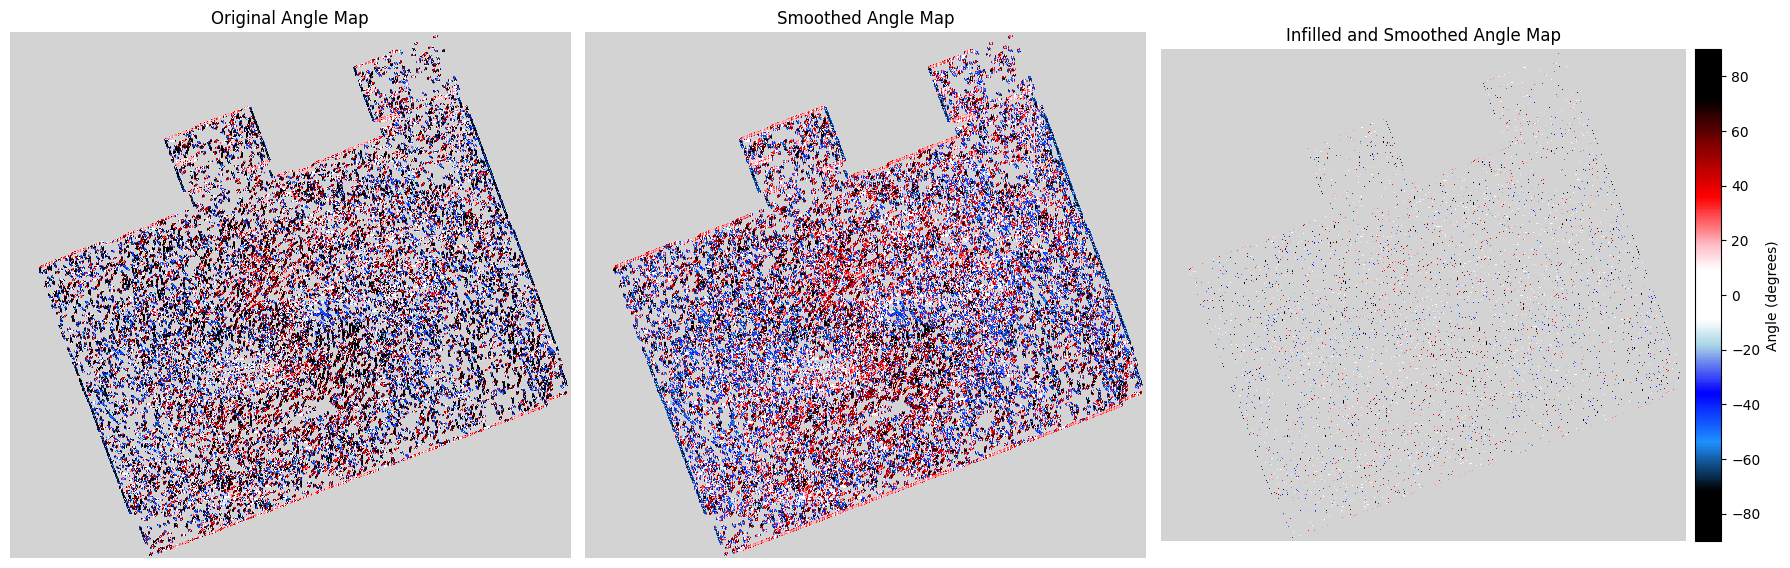

Smoothed angle map saved as C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\smoothed_angles.png


In [ ]:
importlib.reload(PF)
smoothed_angles = r'C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\smoothed_angles.png'


smoother_angle_map, smoothed_angled_map = PF.plot_arctan_with_smoothing(sobel_y, sobel_x, img, 3, smoothed_angles)

Number of hexagons: 1558
0.998612713545277 0.022787568847935494


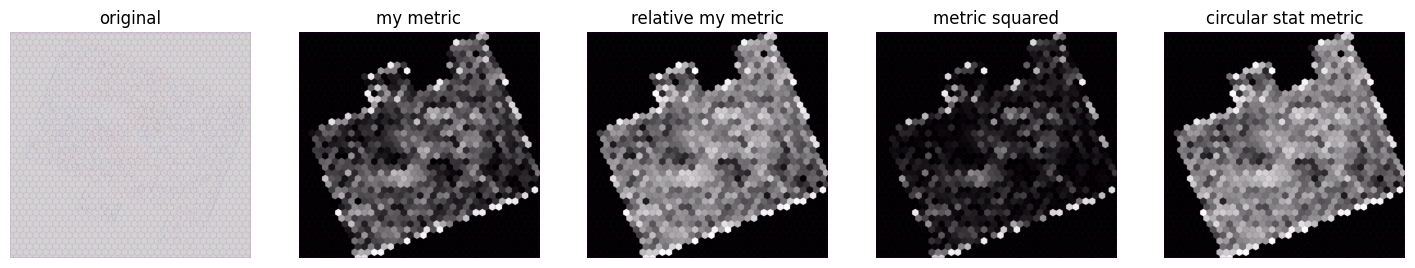

In [ ]:

# Reload your GUI module if necessary
importlib.reload(myGUI)
importlib.reload(Metric)
import pandas as pd 

# Paths and image loading
original_image_path = r'C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\smoothed_angles.png'
img = cv2.imread(original_image_path, cv2.COLOR_BGR2RGB)

# Hexagon settings
hexagon_size = 40
hexagons, hexagon_image_og = myGUI.display_image_with_hexagons(original_image_path, hexagon_size)
hexagon_centers = [x[0] for x in hexagons]
hexagon_corners = [x[1] for x in hexagons]

hex_dict = {}

# Process each hexagon
for i in range(len(hexagon_corners)):
    mask = myGUI.get_hexagon_mask(img.shape, hexagon_corners[i])
    data_in_hexagon = smoother_angle_map[mask == 255]
    data_in_hexagon = [x for x in data_in_hexagon if not np.isnan(x)]
    if len(data_in_hexagon) > 10 and np.mean(data_in_hexagon) != 0:
        hex_dict[hexagon_centers[i]] = (Metric.compute_my_metric(data_in_hexagon), len(data_in_hexagon), Metric.alignment_metric(data_in_hexagon))
    else:
        hex_dict[hexagon_centers[i]] = (np.nan, np.nan, np.nan)
print(f'Number of hexagons: {len(hexagon_centers)}')

# Create a new image to draw the hexagons filled with the alignment metric colors
hexagon_image1 = Image.new("RGB", (img.shape[1], img.shape[0]))
hexagon_image2 = Image.new("RGB", (img.shape[1], img.shape[0]))
hexagon_image3 = Image.new("RGB", (img.shape[1], img.shape[0]))
hexagon_image4 = Image.new("RGB", (img.shape[1], img.shape[0]))

draw1 = ImageDraw.Draw(hexagon_image1)
draw2 = ImageDraw.Draw(hexagon_image2)
draw3 = ImageDraw.Draw(hexagon_image3)
draw4 = ImageDraw.Draw(hexagon_image4)


count = 0

# Save hex_dict to CSV
csv_path = r'C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\PHANGSDustFill\thresholded_image.csv'
with open(csv_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Hexagon Center', 'Number of Pixels', 'Alignment Metric', 'Adjusted Metric', 'Metric Squared', 'metric2'])
    # Extract the first elements from each tuple
    metrics = [info[0] for info in hex_dict.values() if not np.isnan(info[0])]
    metrics_2 = [info[2] for info in hex_dict.values() if not np.isnan(info[2])]

    # Calculate the max and min values of the first elements
    max_metric = max(metrics_2)
    min_metric = min(metrics_2)
    print(max_metric,min_metric)
    for center, info in hex_dict.items():
        metric = info[0]
        number_of_pixels = info[1]
        metric_2 = info[2]
        adjusted_metric = (metric_2 - min_metric)/(max_metric-min_metric)
        metric_squared= metric**2
        writer.writerow([center, number_of_pixels, metric, adjusted_metric, metric_squared, metric_2])
        if not np.isnan(metric) and not np.isnan(adjusted_metric):
            grayscale_value1 = int(metric *255)  # Map to grayscale (0 to 255)
            grayscale_value2 = int(adjusted_metric*255)
            grayscale_value3 = int(metric_squared*255)
            grayscale_value4 = int(metric_2*255)
            corners = hexagon_corners[count]
            draw1.polygon(corners, fill=(grayscale_value1, grayscale_value1, grayscale_value1), outline="purple")
            draw2.polygon(corners, fill=(grayscale_value2, grayscale_value2, grayscale_value2), outline="purple")
            draw3.polygon(corners, fill=(grayscale_value3, grayscale_value3, grayscale_value3), outline="purple")
            draw4.polygon(corners, fill=(grayscale_value4, grayscale_value4, grayscale_value4), outline="purple")
        else:
            corners = hexagon_corners[count]
            draw1.polygon(corners, fill=(0, 0, 0), outline="purple")
            draw2.polygon(corners, fill=(0, 0, 0), outline="purple")
            draw3.polygon(corners, fill=(0, 0, 0), outline="purple")
            draw4.polygon(corners, fill=(0, 0, 0), outline="purple")
        count += 1


# Display the original and processed images
fig, ax = plt.subplots(1, 5, figsize=(18, 18))  # Adjust the figsize as needed

ax[0].imshow(np.flipud(hexagon_image_og))
ax[0].set_title('original')
ax[0].axis('off')  # Hide axes if you want to only show the image

ax[1].imshow(np.flipud(hexagon_image1), cmap='gray')  # Assuming hexagon_image1 is grayscale
ax[1].set_title('my metric')
ax[1].axis('off')  # Hide axes if you want to only show the image

ax[2].imshow(np.flipud(hexagon_image2), cmap='gray')  # Assuming hexagon_image2 is grayscale
ax[2].set_title('relative my metric')
ax[2].axis('off')  # Hide axes if you want to only show the image

ax[3].imshow(np.flipud(hexagon_image3), cmap='gray')  # Assuming hexagon_image2 is grayscale
ax[3].set_title('metric squared')
ax[3].axis('off')  # Hide axes if you want to only show the image

ax[4].imshow(np.flipud(hexagon_image4), cmap='gray')  # Assuming hexagon_image2 is grayscale
ax[4].set_title('circular stat metric')
ax[4].axis('off')  # Hide axes if you want to only show the image

plt.show()

In [ ]:
importlib.reload(myGUI)
importlib.reload(Metric)
original_image_path = r'C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\smoothed_angles.png'
csv_path = r'C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\PHANGSDustFill\thresholded_image.csv'
data_array = smoother_angle_map
myGUI.run_hexagon_analysis(original_image_path, csv_path, data_array,  hexagon_size)